In [13]:
!ls "Semantic segmentation dataset.zip"

'Semantic segmentation dataset.zip'


In [ ]:
!unzip "Semantic segmentation dataset.zip"

In [15]:
import os
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
import random

In [16]:
minmaxscaler=MinMaxScaler()

In [17]:
for path, subdirs, files in os.walk("Semantic segmentation dataset"):
  dir_name=path.split(os.path.sep)[-1]
  # print(dir_name)
  if dir_name=='masks': # we can replace masks with images if we want to process them
    images=os.listdir(path)
    # print(images)
    for i, image_name in enumerate(images):
      if image_name.endswith('.png'):
        # print(image_name)
        a = True

In [19]:
image_patch_size = 256

#logic for applying patching
(image.shape[1]//image_patch_size)*image_patch_size

In [20]:
image_dataset = []
mask_dataset = []

for tile_id in range(1, 8):
    for image_id in range(1, 9):

        # ---------- READ IMAGE ----------
        img_path = f"Semantic segmentation dataset/Tile {tile_id}/images/image_part_00{image_id}.jpg"
        image = cv2.imread(img_path)

        if image is None:
            continue

        size_x = (image.shape[1] // image_patch_size) * image_patch_size
        size_y = (image.shape[0] // image_patch_size) * image_patch_size

        image = image[:size_y, :size_x]
        image = image.astype("float32") / 255.0

        image_patches = patchify(
            image,
            (image_patch_size, image_patch_size, 3),
            step=image_patch_size
        )

        # ---------- READ MASK ----------
        mask_path = f"Semantic segmentation dataset/Tile {tile_id}/masks/image_part_00{image_id}.png"
        mask = cv2.imread(mask_path)

        if mask is None:
            continue

        mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        mask = mask[:size_y, :size_x]

        mask_patches = patchify(
            mask,
            (image_patch_size, image_patch_size, 3),
            step=image_patch_size
        )

        # ---------- STORE PATCHES ----------
        for i in range(image_patches.shape[0]):
            for j in range(image_patches.shape[1]):
                image_dataset.append(image_patches[i, j])
                mask_dataset.append(mask_patches[i, j])


In [21]:
print(len(image_dataset))
print(len(mask_dataset))

840
840


In [22]:
image_dataset=np.array(image_dataset)
mask_dataset=np.array(mask_dataset)

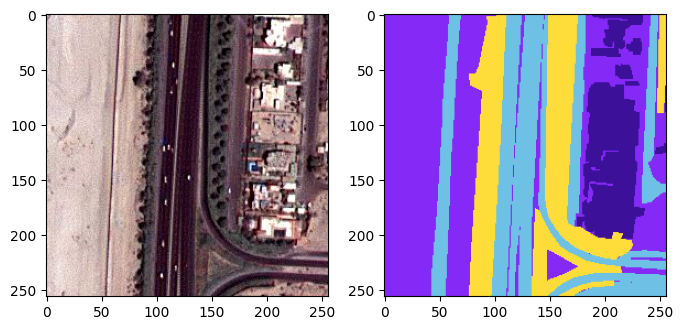

In [45]:
#------rendering the images------

random_index = random.randint(0, len(image_dataset))

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(image_dataset[random_index][0])
plt.subplot(1,2,2)
plt.imshow(mask_dataset[random_index][0])

processing the image mask labels

generating the one hot encoding for the labels

In [25]:
#hex value to rgb
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building=np.array(
    tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land=np.array(
    tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road=np.array(
    tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))

class_vegetation ='#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation=np.array(
    tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water=np.array(
    tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled=np.array(
    tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))





defining rgb to label

In [26]:
label = mask_patches

In [27]:
def rgb_to_label(label):
    label_segment = np.zeros(label.shape[:2], dtype=np.uint8)

    label_segment[np.all(label == class_water, axis=-1)] = 0
    label_segment[np.all(label == class_land, axis=-1)] = 1
    label_segment[np.all(label == class_road, axis=-1)] = 2
    label_segment[np.all(label == class_building, axis=-1)] = 3
    label_segment[np.all(label == class_vegetation, axis=-1)] = 4
    label_segment[np.all(label == class_unlabeled, axis=-1)] = 5

    return label_segment


In [28]:
labels = []
for i in range(0,len(mask_dataset)):
  label=rgb_to_label(mask_dataset[i][0])
  labels.append(label)

In [29]:
labels=np.array(labels)

In [30]:
labels = np.expand_dims(labels, axis=3)

In [ ]:
labels[100]

In [32]:
print("Total unique labels based on the masks: ",format(np.unique(labels)))

Total unique labels based on the masks:  [0 1 2 3 4 5]


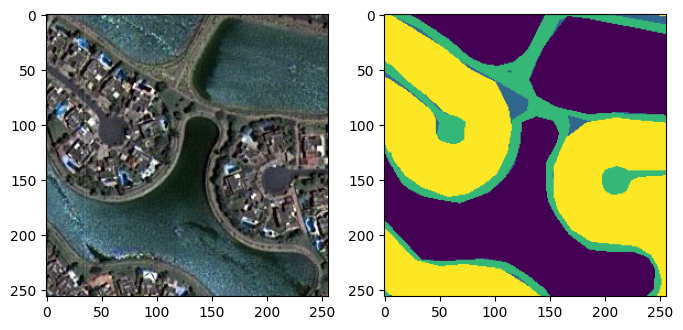

In [44]:
random_index = random.randint(0, len(image_dataset))

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(image_dataset[random_index][0])
plt.subplot(1,2,2)
plt.imshow(labels[random_index][:,:,0])

In [34]:
total_classes = len(np.unique(labels))

In [35]:
from tensorflow.keras.utils import to_categorical

In [36]:
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)

In [37]:
master_training_dataset = image_dataset

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
x_train,x_test,y_train,y_test = train_test_split(master_training_dataset, labels_categorical_dataset, test_size=0.10, random_state=100)

In [40]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(756, 1, 256, 256, 3)
(84, 1, 256, 256, 3)
(756, 256, 256, 6)
(84, 256, 256, 6)


In [41]:
image_height = x_train.shape[2]
image_width = x_train.shape[3]
image_channels = x_train.shape[4]

In [42]:
print(f"image height: {image_height}")
print(f"image width: {image_width}")
print(f"image channels: {image_channels}")

image height: 256
image width: 256
image channels: 3
